In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from publish import *

# MEAT PER STOCK PRICE TRAJECTORY

#### Motivated by the strong correlation between meat production and stock price, we conjecture that by dividing meat production by the price of SPY stock, we remove any bias from economic factors (e.g. the recession and covid) and hope to isolate the affects, if any, of veganism

In [3]:
production = pd.read_csv("Datathon Data/Meat_Stats_Meat_Production.csv")
stocks = pd.read_csv("Datathon Data/all_stock_and_etfs.csv")

In [4]:
TICKER = "SPY" # We want to track the S&P 500
START = 2001
VEGAN_START = 2017

In [5]:
stocks = stocks[stocks["Ticker_Symbol"] == TICKER]

stocks["Year"] = stocks["Date-Time"].apply(lambda x: int(x.split("-")[0]))
stocks["Month"] = stocks["Date-Time"].apply(lambda x: int(x.split("-")[1]))
stocks["Day"] = stocks["Date-Time"].apply(lambda x: int(x.split("-")[2]))

stocks = stocks.reset_index().drop(["Date-Time", "index"], axis=1)

In [6]:
stock_df = pd.DataFrame(columns=["Time", "Price"] )

for year in range(START, 2025):
    for month in range(1, 13):
        month_stocks = stocks[(stocks["Year"] == year) & (stocks["Month"] == month)]

        if len(month_stocks) == 0:
            continue

        price = month_stocks["Close"].values[-1] # This ensures the price is as close to the first of the month as we can get
        
        stock_df.loc[len(stock_df)] = [(year + (month - 1)/12), price]

stock_df

,Time,Price
0,2001.000000,128.8125
1,2001.083333,137.9300
2,2001.166667,124.6000
3,2001.250000,114.2000
4,2001.333333,127.0500
...,...,...
273,2023.750000,427.3100
274,2023.833333,422.6600
275,2023.916667,459.1000
276,2024.000000,472.6500


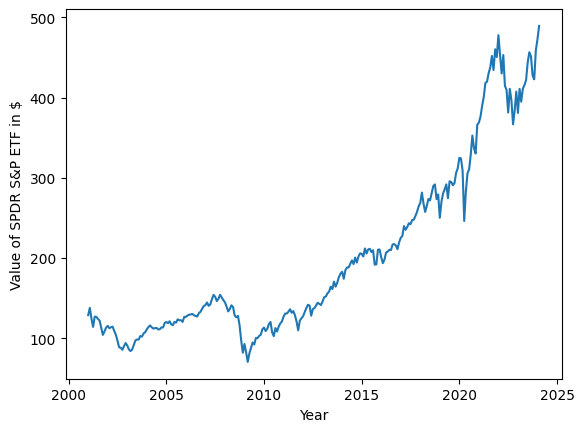

In [7]:
plt.gcf()
plt.plot(stock_df["Time"].values, stock_df["Price"].values)
plt.xlabel("Year")
plt.ylabel("Value of SPDR S&P ETF in $")
plt.show()

In [8]:
# Creating the production df as in MeatDataTrajectory.ipynb
production["Production"] = production["Production"].apply(lambda x: x if type(x) == float else float(x.replace(",", "")))
production["Time"] = production["Year"] + (production["Month"] - 1) / 12
production = production.drop(["Date", "Year", "Month", "Unit", "Type of Meat"], axis=1)

In [9]:
meats = production["Animal"].unique()
production_type = production["Commercial or Federally Inspected"].unique()

In [10]:
production_dfs = {}

for meat in meats:
    for prod in production_type:
        temp_df = production[(production["Animal"] == meat) & (production["Commercial or Federally Inspected"] == prod)].reset_index().drop(["index"], axis=1)

        if len(temp_df) == 0:
            continue

        # This code block explained in MeatDataScraping.ipynb
        for i in range(1, len(temp_df) - 1):
            if temp_df.at[i, "Production"] > 2 * temp_df.at[i - 1, "Production"]:
                if pd.isnull(temp_df.at[i + 1, "Production"]) and pd.isnull(temp_df.at[i + 2, "Production"]):
                    temp_df.at[i + 2, "Production"] = temp_df.at[i, "Production"] / 3
                    temp_df.at[i + 1, "Production"] = temp_df.at[i, "Production"] / 3
                    temp_df.at[i, "Production"] /=3

        # Turkey, Federally Inspected dataset has an error
        if (meat, prod) == ("Turkey", "Federally Inspected"):
            temp_df = temp_df.drop(temp_df[temp_df["Time"] < 1940].index)

        # This information is held in the name of the dataframe
        temp_df = temp_df.drop(["Animal", "Commercial or Federally Inspected"], axis=1)

        production_dfs[f"{meat}, {prod}"] = temp_df

In [11]:
production_dfs_animal = {}

for label in production_dfs:
    animal, _ = label.split(",")

    if animal not in production_dfs_animal:
        production_dfs_animal[animal] = production_dfs[label][production_dfs[label]["Time"] >= START]
    else:
        production_dfs_animal[animal].loc[:, "Production"] = production_dfs_animal[animal]["Production"].values + production_dfs[label][production_dfs[label]["Time"] >= START]["Production"].values 

In [12]:
total_df = []

for animal in production_dfs_animal:
    if len(total_df) == 0:
        total_df = production_dfs_animal[animal][production_dfs_animal[animal]["Time"] >= START]
    else:
        total_df.loc[:, "Production"] = total_df["Production"].values + production_dfs_animal[animal][production_dfs_animal[animal]["Time"] >= START]["Production"].values

total_df

,Production,Time
0,13156.6,2023.916667
1,13685.6,2023.833333
2,14154.8,2023.750000
3,12994.7,2023.666667
4,13939.4,2023.583333
...,...,...
271,11023.0,2001.333333
272,9984.9,2001.250000
273,10513.3,2001.166667
274,9574.1,2001.083333


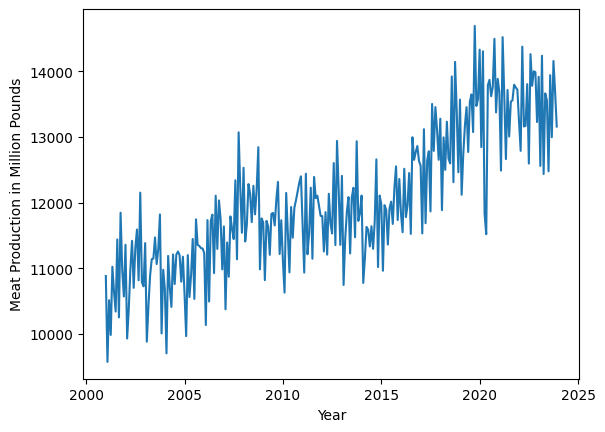

In [13]:
plt.gcf()
plt.plot(total_df["Time"], total_df["Production"])
plt.xlabel("Year")
plt.ylabel("Meat Production in Million Pounds")
plt.show()

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
# Now dividing by stock price, to try and eliminate economic factors
final_df = pd.merge(total_df, stock_df, on="Time")
final_df["Economic Adjusted Production 1"] = final_df["Production"] / final_df["Price"]

final_df

,Production,Time,Price,Economic Adjusted Production 1
0,13156.6,2023.916667,459.1000,28.657373
1,13685.6,2023.833333,422.6600,32.379691
2,14154.8,2023.750000,427.3100,33.125366
3,12994.7,2023.666667,451.1900,28.800949
4,13939.4,2023.583333,456.4800,30.536716
...,...,...,...,...
271,11023.0,2001.333333,127.0500,86.761118
272,9984.9,2001.250000,114.2000,87.433450
273,10513.3,2001.166667,124.6000,84.376404
274,9574.1,2001.083333,137.9300,69.412746


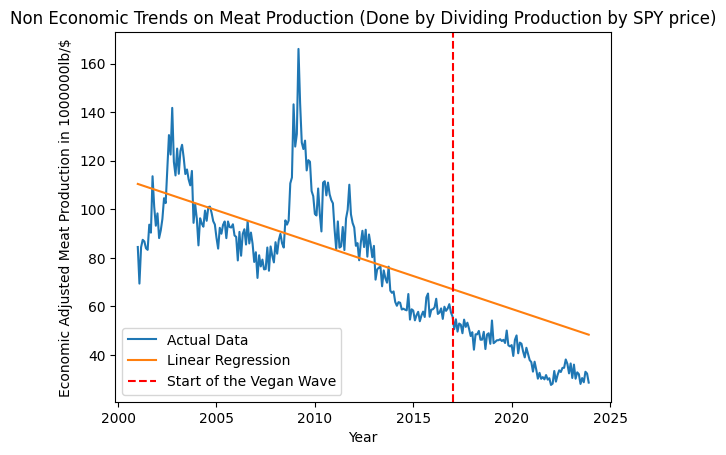

In [16]:
xs1 = final_df[final_df["Time"] <= VEGAN_START]["Time"].values.reshape(-1, 1)
ys1 = final_df[final_df["Time"] <= VEGAN_START]["Economic Adjusted Production 1"].values

linear_model1 = LinearRegression()
linear_model1.fit(xs1, ys1)

gradient1 = linear_model1.coef_
intercept1 = linear_model1.intercept_

plt.gcf()
plt.plot(final_df["Time"], final_df["Economic Adjusted Production 1"], label="Actual Data")
plt.plot(final_df["Time"], gradient1 * final_df["Time"] + intercept1, label="Linear Regression")
plt.axvline(VEGAN_START, color='red', linestyle="--", label="Start of the Vegan Wave")
plt.xlabel("Year")
plt.ylabel("Economic Adjusted Meat Production in 1000000lb/$")
plt.title("Non Economic Trends on Meat Production (Done by Dividing Production by SPY price)")
plt.legend()
plt.show()

#### The spikes arise as the price is much more volatile than meat production
#### To remove this volatility, we can divide by a linear regression curve rather than each individual price value

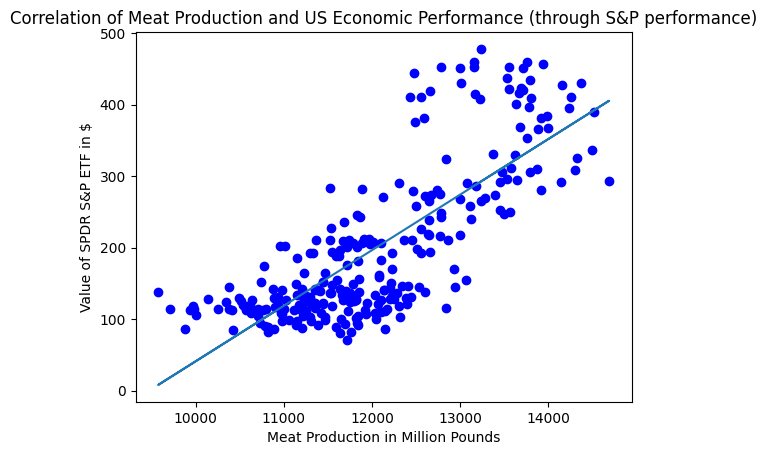

In [17]:
xs2 = final_df["Production"].values.reshape(-1, 1) 
ys2 = final_df["Price"].values 

# xs2 = final_df[final_df["Time"] <= VEGAN_START]["Production"].values.reshape(-1, 1)
# ys2 = final_df[final_df["Time"] <= VEGAN_START]["Price"].values

linear_model2 = LinearRegression()
linear_model2.fit(xs2, ys2)

gradient2 = linear_model2.coef_
intercept2 = linear_model2.intercept_

plt.gcf()
plt.plot(xs2, ys2, "bo")
plt.plot(xs2, gradient2 * xs2 + intercept2)
plt.xlabel("Meat Production in Million Pounds")
plt.ylabel("Value of SPDR S&P ETF in $")
plt.title("Correlation of Meat Production and US Economic Performance (through S&P performance)")
plt.show()

In [18]:
correlation_coef = np.corrcoef(xs2.flatten(), ys2)[0, 1]

correlation_coef

0.7779620613140048

In [19]:
final_df["Economic Adjusted Production 2"] = final_df["Production"] / (final_df["Production"] * gradient2 + intercept2)

final_df

,Production,Time,Price,Economic Adjusted Production 1,Economic Adjusted Production 2
0,13156.6,2023.916667,459.1000,28.657373,45.965538
1,13685.6,2023.833333,422.6600,32.379691,41.810875
2,14154.8,2023.750000,427.3100,33.125366,38.911380
3,12994.7,2023.666667,451.1900,28.800949,47.486453
4,13939.4,2023.583333,456.4800,30.536716,40.166856
...,...,...,...,...,...
271,11023.0,2001.333333,127.0500,86.761118,91.489305
272,9984.9,2001.250000,114.2000,87.433450,250.613739
273,10513.3,2001.166667,124.6000,84.376404,129.971550
274,9574.1,2001.083333,137.9300,69.412746,1207.356195


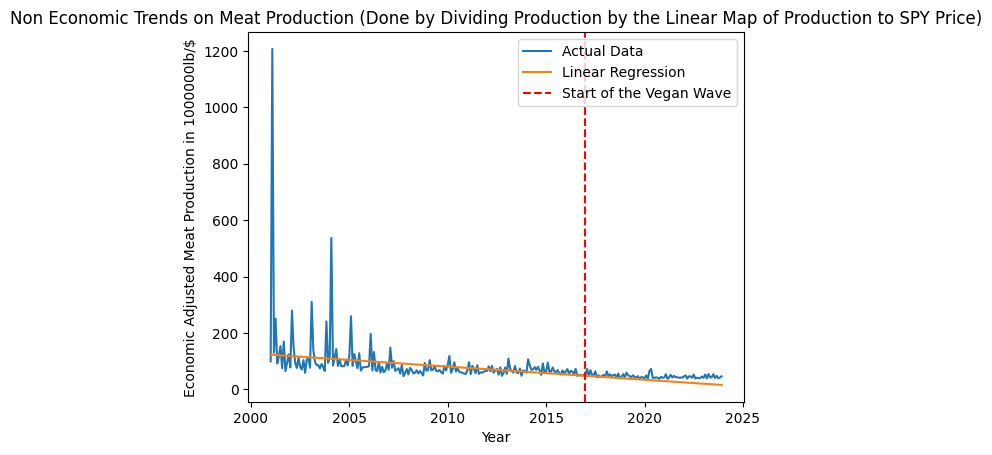

In [20]:
xs3 = final_df[final_df["Time"] <= VEGAN_START]["Time"].values
ys3 = final_df[final_df["Time"] <= VEGAN_START]["Economic Adjusted Production 2"].values

xs3 = np.delete(xs3, -3).reshape(-1, 1) # Deleting an anomolous datapoint from the linear regression analysis
ys3 = np.delete(ys3, -3)

linear_model3 = LinearRegression()
linear_model3.fit(xs3[:-2], ys3[:-2])

gradient3 = linear_model3.coef_
intercept3 = linear_model3.intercept_

plt.gcf()
plt.plot(final_df["Time"], final_df["Economic Adjusted Production 2"], label="Actual Data")
plt.plot(final_df["Time"], gradient3 * final_df["Time"] + intercept3, label="Linear Regression")
plt.axvline(VEGAN_START, color='red', linestyle="--", label="Start of the Vegan Wave")
plt.xlabel("Year")
plt.ylabel("Economic Adjusted Meat Production in 1000000lb/$")
plt.title("Non Economic Trends on Meat Production (Done by Dividing Production by the Linear Map of Production to SPY Price)")
plt.legend()
plt.show()

#### From this, we see that if the relationship between economic growth and meat production is truly as we have modelled then veganism has had no effect

#### Finally, I want to see how the linear regression curve and strength vary before and after the vegan wave

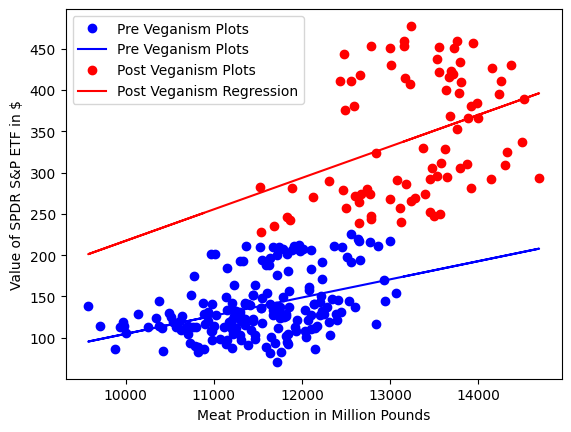

In [21]:
xs_bef = final_df[final_df["Time"] <= VEGAN_START]["Production"].values.reshape(-1, 1)
ys_bef = final_df[final_df["Time"] <= VEGAN_START]["Price"].values

xs_aft = final_df[final_df["Time"] > VEGAN_START]["Production"].values.reshape(-1, 1)
ys_aft = final_df[final_df["Time"] > VEGAN_START]["Price"].values

linear_model_bef = LinearRegression()
linear_model_bef.fit(xs_bef, ys_bef)
bef_gradient = linear_model_bef.coef_
bef_intercept = linear_model_bef.intercept_

linear_model_aft = LinearRegression()
linear_model_aft.fit(xs_aft, ys_aft)
aft_gradient = linear_model_aft.coef_
aft_intercept = linear_model_aft.intercept_

plt.gcf()
plt.plot(xs_bef, ys_bef, "bo", label="Pre Veganism Plots")
plt.plot(final_df["Production"], final_df["Production"] * bef_gradient + bef_intercept, color="blue", label="Pre Veganism Plots")
plt.plot(xs_aft, ys_aft, "ro", label="Post Veganism Plots")
plt.plot(final_df["Production"], final_df["Production"] * aft_gradient + aft_intercept, color="red", label="Post Veganism Regression")
plt.xlabel("Meat Production in Million Pounds")
plt.ylabel("Value of SPDR S&P ETF in $")
plt.legend()
plt.show()

#### Interestingly, the gradient of the post vegan regression is steeper, suggesting that meat production is more sensitive to the strength of the US economy

#### T-Test on the price changes

In [26]:
bef_diffs = np.diff(final_df[final_df["Time"] <= VEGAN_START]["Economic Adjusted Production 1"])
aft_diffs = np.diff(final_df[final_df["Time"] > VEGAN_START]["Economic Adjusted Production 1"])

bef_diffs, aft_diffs

(array([  1.76886574,   3.41355085,  -1.77968817,  -0.97640506,
          1.70501649,  -5.00869305,   4.31725487,  -1.7220166 ,
         -0.5593589 ,   6.24249074,  -3.53306354,  -0.76657973,
         -0.20482765,  -2.89028962,   9.55546011,  -1.58513968,
         -8.07612648,   2.21148648,  -1.59667897,  -2.36599011,
          3.88211794,  -1.37762073,  -2.13232444,   4.02157995,
          0.52613831,  -4.22783411,  10.51804446,  -6.72938084,
          0.28045011,   0.40043864,  -0.33133723,   2.78109914,
          0.25137893,  -1.49198738,   1.58457579,   4.31356546,
         -0.58118457,   0.91199329,   9.8585912 ,  -6.59318548,
          1.85210773,   3.20387126,  -6.53701828,   8.03811871,
         -0.36378582,  -0.70847441,  -4.21793036,  13.89238536,
         -4.65274588,   5.13480976,   4.21032132,  -9.13581211,
         11.09241223,  -7.1341653 ,   6.69545841,  -4.93718029,
         -7.19496179,   7.04828797,  -1.0968183 ,   7.53642589,
          1.89195725,   3.52097749,  12.

In [30]:
from scipy import stats

In [28]:
np.var(bef_diffs), np.var(aft_diffs)

(69.64451829541754, 13.825307639316387)

In [32]:
stats.ttest_ind(bef_diffs, aft_diffs, equal_var = True)

TtestResult(statistic=-0.1232063708740418, pvalue=0.9020346696813268, df=272.0)